# Commercial aircraft fuel calculator with Aviator

This tutorial demonstrates how to use Aviator to model an aircraft's flight and determine its fuel usage using Python and PySTK. It is inspired by [this training](https://help.agi.com/stk/Content/training/StartAMM.htm).

## What is an Aviator mission?

Aviator provides an enhanced method for modeling aircraft - more accurate and more flexible than the standard Great Arc propagator. With Aviator, the aircraft's route is modeled by a sequence of curves parametrized by well-known performance characteristics of aircraft, including cruise airspeed, climb rate, roll rate, and bank angle. The precise state of an aircraft at any given time can be computed analytically - swiftly and without excessive data storage needs. Aviator capability is built upon the concept of an aircraft's mission, as opposed to a mere point-to-point route. An aircraft using Aviator as its propagator can conduct a transit between two points that is more complex than a great arc, and furthermore, can carry out operations that are more complex than a transit between two points (e.g., holding in a pattern). The process of defining a mission in Aviator, therefore, encompasses much more than merely selecting route points. A mission includes the flight procedures and performance characteristics of the aircraft and describes not only where the aircraft goes, but how it goes there and what it does along the way. Defining a mission consists of configuring the aircraft model, defining the phases of the mission and selecting performance models for each, and defining the procedures that the aircraft will execute in each phase.

## Problem statement

The Telluride Regional Airport runway sits on a plateau and dips slightly in the center, providing a challenging landing for pilots. Weather conditions in the area also often rapidly change, and pilots must be aware of issues impacting the airfield such as high terrain which exceeds $14,000$ ft and the runway's location on a plateau with a thousand-foot drop should the aircraft slide off of the runway.

A small commuter jet flies from Colorado Springs Municipal Airport to Telluride Regional airport. The jet takes off from Colorado Springs Municipal Airport and flies direct to the radio beacon at Blue Mesa, then flies to the Cones radio beacon, then lands at Telluride. The jet has an empty weight of $31000$ lb, accounting for the pilot, instructor, and baggage. The flight takes place during constant wind conditions, with wind with a bearing of $180^\circ$ and a speed of $20$ nm/hr. Model the jet's flight as a mission consisting of one phase, taking off from a runway at Colorado Springs Municipal Airport, and landing at Telluride Regional. Determine how much fuel is required for the mission, and how much fuel is left unused upon landing.

The mission parameters are:

- A basic acceleration performance model with level turns and climb and descent transitions scaled by atmosphere density, and a basic fixed wing strategy for modeling aerodynamics and propulsion
- A basic climb performance model using aero/propulsion fuel flow
- A basic cruise performance model designating that the aircraft climbs to $25000$ ft and levels off
- A basic descent performance model using aero/propulsion fuel flow
- A basic landing performance model using aero/propulsion fuel flow
- A basic takeoff performance model using aero/propulsion fuel flow

The mission consists of 1 phase with 5 procedures:

- A takeoff from Colorado Springs, using a low runway heading and a runway altitude offset of $7$ ft
- A basic maneuver consisting of a $20$ nm flight straight ahead, with an altitude increase of $10000$ ft
- A basic point to point procedure flying the aircraft directly from the end of the last procedure to the Blue Mesa radio beacon, with a turn factor of $5$
- A basic point to point procedure flying the aircraft from Blue Mesa to the Cones radio beacon, with a constant altitude of $15000$ ft, a turn factor of $5$, and a cruise airspeed of $250$ nm/hr
- A landing from Cones to the Telluride Regional Airport, with an Intercept Glideslope approach mode, a low runway heading, and an altitude offset of $7$ ft

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Create a new scenario in STK by running:

In [2]:
root = stk.new_object_root()
root.new_scenario("CommercialFlight")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

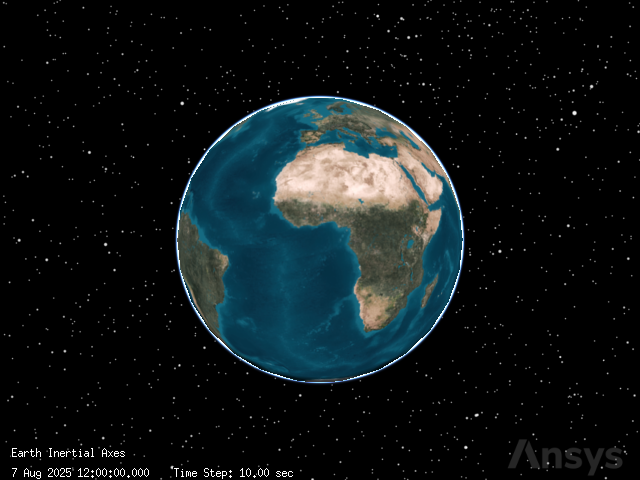

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe_plotter = GlobeWidget(root, 640, 480)
globe_plotter.show()

Show a 2D graphics window by running:

RFBOutputContext()

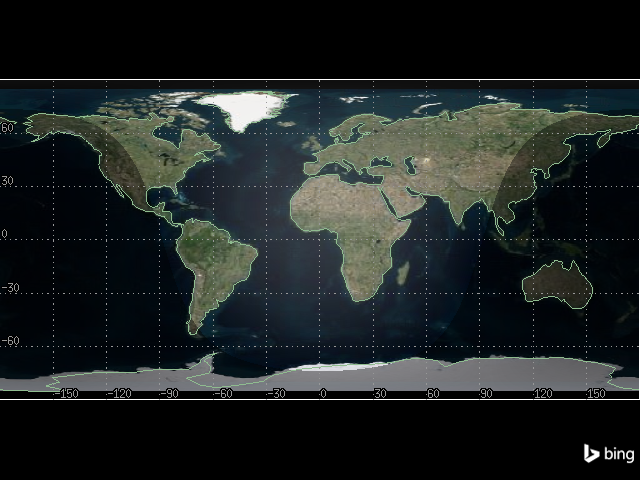

In [4]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import MapWidget


map_plotter = MapWidget(root, 640, 480)
map_plotter.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [5]:
scenario = root.current_scenario
scenario.set_time_period("1 Aug 2020 18:00:00.000", "1 Aug 2020 19:00:00.000")
root.rewind()

## Add an aircraft

Insert an aircraft object to model the jet that flies between Colorado Springs and Telluride:

In [6]:
from ansys.stk.core.stkobjects import STKObjectType


aircraft = root.current_scenario.children.new(
    STKObjectType.AIRCRAFT, "CommercialAircraft"
)

The `IAviatorPropagator` interface allows access to all Aviator functions. Through the propagator, it is possible to access the aircraft's mission and plan its route, as well as access the Aviator catalogs, which allow loading and saving aircraft, airports, navaids, runways, VTOL points, and waypoints. To start using Aviator capabilities, first set the aircraft's propagator type to the Aviator propagator:

In [7]:
from ansys.stk.core.stkobjects import PropagatorType


aircraft.set_route_type(PropagatorType.AVIATOR)

Then, use the aircraft's `route` property to access the `aviator_propagator` property, which holds an `IAviatorPropagator` object:

In [8]:
aviator_propagator = aircraft.route.aviator_propagator

## Insert a runway at Telluride Regional Airport

It is now possible to use the Aviator propagator to insert places of interest. Use the Aviator runway catalog to insert a runway at Telluride Regional Airport by loading a file containing information about runways. This file is included with the STK installation.

First, get the runway catalog:

In [9]:
runway_catalog = aviator_propagator.aviator_catalog.runway_category

Then, upload the "FAANFD18" file provided with the STK install containing information about runways in ARINC424 format. To do so, use a Connect command to find the STK installation directory and navigate to the proper file, then set the file as the master data file for ARINC424 runways:

In [10]:
import pathlib


install_dir = root.execute_command("GetDirectory / STKHome")[0]
runway_catalog.arinc424_runways.master_data_filepath = str(
    pathlib.Path(install_dir)
    / "Data"
    / "Resources"
    / "stktraining"
    / "samples"
    / "FAANFD18"
)

The runway catalog now contains information about the runways included in the file. View the names of the first $5$ runways (alphabetically) in the catalog:

In [11]:
runway_catalog.arinc424_runways.child_names[:5]

['A L MANGHAM JR. RGNL 18 36',
 'A. PAUL VANCE FREDERICKTOWN RG 01 19',
 'ABBEVILLE CHRIS CRUSTA MEMORIA 16 34',
 'ABERDEEN RGNL 13 31',
 'ABERDEEN RGNL 17 35']

Determine how many runways are included in the catalog:

In [12]:
print(
    f"There are {len(runway_catalog.arinc424_runways.child_names)} runways stored in the catalog."
)

There are 5004 runways stored in the catalog.


Now, use the catalog to select the runway at Telluride Regional Airport. Later in the scenario, the runway is included in the aircraft's mission planning as the landing destination.

In [13]:
telluride_runway = runway_catalog.arinc424_runways.get_arinc424_item(
    "TELLURIDE RGNL 09 27"
)

The catalog item stores information about the runway, including its length, width, location, and bearing. Determine the length of the runway:

In [14]:
print(f"Telluride runway is {telluride_runway.get_value('Length')} ft. long")

Telluride runway is 7111.0 ft. long


## Insert the Telluride Regional Airport

Insert a place object to represent Telluride Regional Airport:

In [15]:
telluride = root.current_scenario.children.new(STKObjectType.PLACE, "Telluride")

The Telluride runway catalog object stores information about the runway's location. Using that object, assign the location of the place object to the runway's using geodetic coordinates:

In [16]:
telluride.position.assign_geodetic(
    telluride_runway.get_value("Latitude"),
    telluride_runway.get_value("Longitude"),
    telluride_runway.get_value("Altitude"),
)

## Insert the Colorado Springs Municipal Airport

First, use the Aviator runway catalog to get a runway at Colorado Springs Municipal Airport:

In [17]:
colorado_springs_runway = runway_catalog.arinc424_runways.get_arinc424_item(
    "CITY OF COLORADO SPRINGS MUNI 17L 35R"
)

Then, insert a place object to represent the airport:

In [18]:
colorado_springs = root.current_scenario.children.new(
    STKObjectType.PLACE, "ColoradoSprings"
)

Use the runway catalog item to assign the place object's location to the same coordinates as the runway's:

In [19]:
colorado_springs.position.assign_geodetic(
    colorado_springs_runway.get_value("Latitude"),
    colorado_springs_runway.get_value("Longitude"),
    colorado_springs_runway.get_value("Altitude"),
)

It is now possible to see both airports in the 2D graphics window:

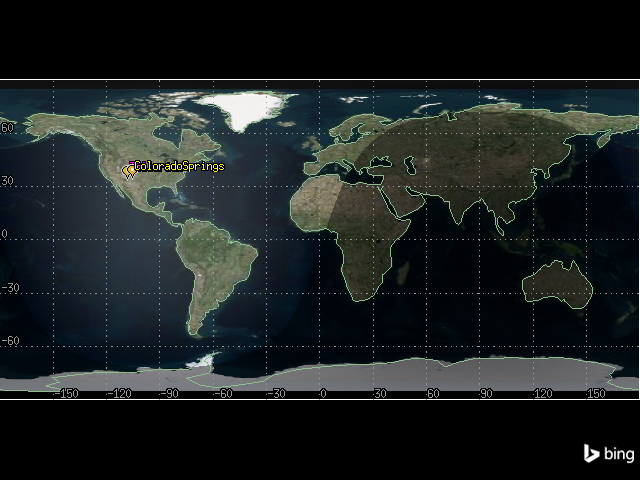

In [20]:
map_plotter.camera.position = [-1090, 35060, 0.0]
map_plotter.show()

## Configure the aircraft model

The Aviator catalog also provides aircraft models, which can be used with STK aircraft objects. An aircraft model defines the physical characteristics of the aircraft, the aircraft configuration, and the modes of flight that define how the aircraft flies in any given situation. Set the aircraft's model to a basic business jet.

First, get the aircraft model catalog using the Aviator propagator:

In [21]:
aircraft_models = aviator_propagator.aviator_catalog.aircraft_category.aircraft_models

Then, get the model corresponding to a basic business jet:

In [22]:
business_jet = aircraft_models.get_aircraft("Basic Business Jet")

Aircraft models are read-only by default, so their performance models cannot be edited. To create a custom aircraft model, duplicate the model from the catalog, then rename it. Remove any catalog item with the same name before doing so.

In [23]:
if aircraft_models.get_as_catalog_source().contains("Basic Business Jet Copy"):
    aircraft_models.get_aircraft("Basic Business Jet Copy").remove()
business_jet.get_as_catalog_item().duplicate().name = "Basic Business Jet Copy"

To assign the model to the aircraft, use the Aviator propagator's mission. An Aviator mission describes an aircraft's flight, including its route, flight procedures, and performance characteristics. Get the mission, then use the `vehicle` property to assign the model:

In [24]:
mission = aviator_propagator.aviator_mission
mission.vehicle = aircraft_models.get_aircraft("Basic Business Jet Copy")

## Configure the aircraft performance models

Aircraft properties provide access to performance models. Performance models are used to define the behavior of the aircraft in flight. By specifying performance models to use with each phase of the mission, it is possible to vary the manner in which the aircraft performs based on the priorities of the mission. Although the aircraft model previously assigned is representative of an aircraft type, it is not representative of a specific aircraft, so it is necessary to customize the model to match desired characteristics.

First, configure the aircraft's acceleration performance model. To do so, first add a phase to the mission. A phase is a logical unit of an aircraft's mission. Performance models can be specified for each phase and are used by the procedures executed within them.

Use the aircraft's mission to select the first phase:

In [25]:
phase = mission.phases[0]

Then, get the phases's acceleration performance model:

In [26]:
acceleration_performance_model = phase.get_performance_model_by_type(
    "Acceleration"
).properties

Through the `IAircraftBasicAccelerationModel` object, it is possible to configure the basic, aerodynamics, and propulsion characteristics of the aircraft. Set the level turns to scale by atmosphere density, which causes the aircraft to consider dynamic pressure when calculating turn radius.

In [27]:
from ansys.stk.core.stkobjects.aviator import AccelerationManeuverMode


acceleration_performance_model.level_turns.maneuver_mode = (
    AccelerationManeuverMode.ACCELERATION_MANEUVER_MODE_DENSITY_SCALE
)

Set the climb and descent transitions to scale by atmosphere density:

In [28]:
acceleration_performance_model.climb_and_descent_transitions.maneuver_mode = (
    AccelerationManeuverMode.ACCELERATION_MANEUVER_MODE_DENSITY_SCALE
)

Then, configure the aerodynamics characteristics by setting the aerodynamic strategy type to basic fixed wing aerodynamics. To do so, use the performance model's `aerodynamics` property, which contains an `IAircraftAero` object:

In [29]:
from ansys.stk.core.stkobjects.aviator import AircraftAerodynamicStrategy


acceleration_performance_model.aerodynamics.aerodynamic_strategy = (
    AircraftAerodynamicStrategy.AIRCRAFT_AERODYNAMIC_BASIC_FIXED_WING
)

Then, set the aircraft's propulsion to also use a basic fixed wing strategy by accessing the performance model's `propulsion` property, which contains an `IAircraftProp` object:

In [30]:
from ansys.stk.core.stkobjects.aviator import AircraftPropulsionStrategy


acceleration_performance_model.propulsion.propulsion_strategy = (
    AircraftPropulsionStrategy.AIRCRAFT_PROPULSION_BASIC_FIXED_WING
)

Next, configure the aircraft's climb performance model. The basic climb performance model defines the flight characteristics of the aircraft while climbing. Select the climb performance model:

In [31]:
climb_performance_model = phase.get_performance_model_by_type("Climb").properties

Configure the model to use aero/propulsion fuel flow:

In [32]:
climb_performance_model.use_aerodynamic_propulsion_fuel = True

Next, configure the aircraft's cruise performance model, which defines the flight characteristics of the aircraft during level flight. Select the cruise performance model:

In [33]:
cruise_performance_model = phase.get_performance_model_by_type("Cruise").properties

The aircraft climbs to $25000$ ft and then levels off. Set the default cruise altitude to $25000$ ft:

In [34]:
cruise_performance_model.default_cruise_altitude = 25000

Then, configure the model to use aero/propulstion fuel flow:

In [35]:
cruise_performance_model.use_aerodynamic_propulsion_fuel = True

Next, configure the aircraft's basic descent, landing, and takeoff performance models. Set all three to use aero/propulsion fuel flow:

In [36]:
descent_performance_model = phase.get_performance_model_by_type("Descent").properties
descent_performance_model.use_aerodynamic_propulsion_fuel = True
landing_performance_model = phase.get_performance_model_by_type("Landing").properties
landing_performance_model.use_aerodynamic_propulsion_fuel = True
takeoff_performance_model = phase.get_performance_model_by_type("Takeoff").properties
takeoff_performance_model.use_aerodynamic_propulsion_fuel = True

## Set the aircraft's fuel and payload

The aircraft has an empty weight of $31000$ lb, accounting for the pilot, instructor, and baggage. To set the aircraft's empty weight, use the mission's `configuration` property:

In [37]:
mission.configuration.empty_weight = 31000

Through the `configuration` property, it is also possible to access detail's about the aircraft's weight and capacity. Determine the aircraft's maximum landing weight:

In [38]:
print(
    f"The aircraft's maximum landing weight is {mission.configuration.max_landing_weight} lb."
)

The aircraft's maximum landing weight is 40000.0 lb.


It is also possible to use the `configuration` property to access the aircraft's internal fuel tanks, stations, and external fuel tanks that are attached to the stations. To do so, use the `get_stations` method:

In [39]:
stations = mission.configuration.get_stations()

Determine the capacity and initial state of the aircraft's fuel tank. Select the aircraft's internal fuel tank from the list of stations:

In [40]:
internal_fuel = stations.get_internal_fuel_tank_by_name("Internal Fuel")

Then, determine the fuel tank's capacity and initial state:

In [41]:
print(
    f"The internal fuel tank has a capacity of {internal_fuel.capacity} lb and initially holds {internal_fuel.initial_fuel_state} lb of fuel"
)

The internal fuel tank has a capacity of 20000.0 lb and initially holds 20000.0 lb of fuel


## Configure the mission wind model

The wind and atmosphere model is used to simulate wind and atmospheric conditions for a scenario, procedure, or mission. Select the wind model:

In [42]:
wind_model = mission.wind_model

By default, the wind model is set to use constant wind, so it is possible in this case to directly use the model's `mode_as_constant` property to set the wind. Set the wind bearing to $180^\circ$ and the wind speed to $20$ nm/hr:

In [43]:
wind_model.mode_as_constant.wind_bearing = 180
wind_model.mode_as_constant.wind_speed = 20

## Create the aircraft's flight plan

The aircraft has one phase in its flight plan. The aircraft takes off from Colorado Springs Municipal Airport and flies direct to Blue Mesa radio beacon. Turning at Blue Mesa , the aircraft flies to Cones, and then begins its final approach and lands at Telluride Regional Airport.

The aircraft will first take off from the Colorado Springs runway named "CITY OF COLORADO SPRINGS MUNI 17L 35R", so the first procedure is a takeoff procedure using a catalog runway as a site type. Insert the first procedure in the phase:

In [44]:
from ansys.stk.core.stkobjects.aviator import ProcedureType, SiteType


takeoff_procedure = phase.procedures.add(
    SiteType.SITE_RUNWAY_FROM_CATALOG, ProcedureType.PROCEDURE_TAKEOFF
)

Then, set the takeoff procedure's site to the catalog entry for the "CITY OF COLORADO SPRINGS MUNI 17L 35R" runway so that the procedure starts from the runway:

In [45]:
takeoff_procedure.site.set_catalog_runway(colorado_springs_runway)

Now, configure the takeoff procedure's properties. Name the takeoff "COS Runway":

In [46]:
takeoff_procedure.name = "COS Runway"

Then, set the runway's heading. The heading refers to the direction that the aircraft is pointing, and is derived from the runway site definition. The first numerical value indicates the bearing relative to magnetic north and the second value indicates the bearing relative to true north. Set the procedure to use the runway's low end:

In [47]:
from ansys.stk.core.stkobjects.aviator import RunwayHighLowEnd


takeoff_procedure.runway_heading_options.runway_mode = RunwayHighLowEnd.LOW_END

Set the runway's altitude offset to $7$ ft:

In [48]:
takeoff_procedure.mode_as_normal.runway_altitude_offset = 7

Then, enable the use of the runway terrain in calculations:

In [49]:
takeoff_procedure.mode_as_normal.use_runway_terrain = True

Because of terrain, the aircraft must gain altitude before flying to Blue Mesa. It will do so in a basic maneuver procedure following takeoff. A basic maneuver procedure is a single action undertaken by the aircraft. It is unlike most procedures in Aviator, which represent sets of actions that together comprise a common flying procedure.

Insert a basic maneuver procedure that starts from the end of the previous procedure:

In [50]:
climb_procedure = phase.procedures.add(
    SiteType.SITE_END_OF_PREV_PROCEDURE, ProcedureType.PROCEDURE_BASIC_MANEUVER
)

Change the procedure's name to "Climb":

In [51]:
climb_procedure.name = "Climb"

Then, configure the aircraft's stop conditions. Each basic maneuver requires at least one stopping condition, which dictates when the maneuver will end regardless of whether any other goals are met. The maneuver will stop if any one of the stopping conditions is met.

Disable the time of flight stop condition:

In [52]:
climb_procedure.use_max_time_of_flight = False

Set a downrange stop condition of $20$ nm:

In [53]:
climb_procedure.use_max_downrange = True
climb_procedure.max_downrange = 20

Then, set the vertical/profile strategies. Set the altitude mode to specify altitude change:

In [54]:
from ansys.stk.core.stkobjects.aviator import AutopilotAltitudeMode


climb_procedure.profile.altitude_mode = (
    AutopilotAltitudeMode.AUTOPILOT_SPECIFY_ALTITUDE_CHANGE
)

Set the relative altitude change to $10000$ ft:

In [55]:
climb_procedure.profile.relative_altitude_change = 10000

The next procedure flies the aircraft to Blue Mesa after it has finished its climb. The site for the procedure is derived from a Navaid in the catalog representing Blue Mesa, and the aircraft flies between two waypoints.

Insert a procedure after the climb procedure, with a site type of `SITE_NAVAID_FROM_CATALOG` and a procedure type of `PROCEDURE_BASIC_POINT_TO_POINT`:

In [56]:
blue_mesa_procedure = phase.procedures.add(
    SiteType.SITE_NAVAID_FROM_CATALOG, ProcedureType.PROCEDURE_BASIC_POINT_TO_POINT
)

Because of the procedure type designation, the procedure's `site` property contains an `ISiteNavaidFromCatalog` object. First, get the navaid catalog item corresponding to "HBU", which is the FAA designator for the Blue Mesa radio site.

In [57]:
blue_mesa_navaid = aviator_propagator.aviator_catalog.navaid_category.arinc424_navaids.get_arinc424_item(
    "HBU"
)

Set the procedure's site to the navaid:

In [58]:
blue_mesa_procedure.site.set_catalog_navaid(blue_mesa_navaid)

Then, add a place object at the navaid's location:

In [59]:
blue_mesa = root.current_scenario.children.new(STKObjectType.PLACE, "BlueMesa")
blue_mesa.position.assign_geodetic(
    blue_mesa_navaid.get_value("Latitude"), blue_mesa_navaid.get_value("Longitude"), 0
)

Now, configure the procedure. The procedure type is a basic point to point procedure, which represents a basic traverse between two waypoints. With this procedure type, the aircraft travels a straight line through 3D space from the end of the previous procedure to the site of the current procedure. It smoothly accelerates/decelerates under a constant climb/descent to arrive at the specified speed, altitude, and heading.

Set the procedure's name to "Blue Mesa":

In [60]:
blue_mesa_procedure.name = "Blue Mesa"

Then, set the procedure to use a fly direct navigation mode. This mode means that the aircraft flies directly to the procedure site from the end of the previous procedure, turning as necessary.

In [61]:
from ansys.stk.core.stkobjects.aviator import PointToPointMode


blue_mesa_procedure.navigation_options.navigation_mode = PointToPointMode.FLY_DIRECT

Next, configure the procedure's enroute options, which define the turning performance characteristics of the aircraft during enroute segments of the procedure. Set the turn factor, which is the maximum amount - expressed as a multiplier - that the turn radius is increased to minimize the bank angle required to complete turns. Set the turn factor to 5:

In [62]:
blue_mesa_procedure.enroute_options.max_turn_radius_factor = 5

Next, insert another basic point to point procedure to fly from Blue Mesa to Cones, which has an FAA designator of "ETL".

In [63]:
cones_procedure = phase.procedures.add(
    SiteType.SITE_NAVAID_FROM_CATALOG, ProcedureType.PROCEDURE_BASIC_POINT_TO_POINT
)

Get the navaid catalog item corresponding to the Cones beacon:

In [64]:
cones_navaid = aviator_propagator.aviator_catalog.navaid_category.arinc424_navaids.get_arinc424_item(
    "ETL"
)

Then, set the procedure's site to the navaid:

In [65]:
cones_procedure.site.set_catalog_navaid(cones_navaid)

Add a place object at the navaid's location:

In [66]:
cones = root.current_scenario.children.new(STKObjectType.PLACE, "Cones")
cones.position.assign_geodetic(
    cones_navaid.get_value("Latitude"), cones_navaid.get_value("Longitude"), 0
)

Set the procedure's name to "Cones":

In [67]:
cones_procedure.name = "Cones"

Then, configure the procedure's altitude options. Altitude parameters define the altitude that the aircraft will attempt to achieve and sustain during the procedure. Set the Use Aircraft Default Cruise Altitude option to false:

In [68]:
cones_procedure.altitude_options.use_default_cruise_altitude = False

Then, set the procedure's altitude to $15000$ ft:

In [69]:
cones_procedure.altitude_options.altitude = 15000

Next, configure the procedure's enroute options to use a turn factor of $5$:

In [70]:
cones_procedure.enroute_options.max_turn_radius_factor = 5

Then, configure the procedure's enroute cruise airspeed options. The enroute cruise airspeed parameters define the airspeed performance characteristics of the aircraft during enroute segments of the procedure. Set the airspeed type to other airspeed, which allows the manual setting of a constant airspeed:

In [71]:
from ansys.stk.core.stkobjects.aviator import CruiseSpeed


cones_procedure.enroute_cruise_airspeed_options.cruise_speed_type = (
    CruiseSpeed.OTHER_AIRSPEED
)

Set the airspeed to $250$ nm/hr using calibrated airspeed.:

In [72]:
from ansys.stk.core.stkobjects.aviator import AirspeedType


cones_procedure.enroute_cruise_airspeed_options.set_other_airspeed(
    AirspeedType.CAS, 250
)

Finally, insert the last procedure in the phase, which is a landing procedure arriving at the Telluride runway. Insert the procedure:

In [73]:
landing_procedure = phase.procedures.add(
    SiteType.SITE_RUNWAY_FROM_CATALOG, ProcedureType.PROCEDURE_LANDING
)

Then, set the site to the Telluride runway:

In [74]:
landing_procedure.site.set_catalog_runway(telluride_runway)

Next, configure the landing procedure. A landing procedure brings an aircraft down from the air to a runway site. Set the procedure's name to "Telluride Runway":

In [75]:
landing_procedure.name = "Telluride Runway"

Set the approach mode, which describes the type of landing, to Intercept Glideslope. An intercept glideslope approach designates that the aircraft performs a landing following VFR flight rules and uses Basic Point to Point methodology to fly to the Initial Approach Fix Range and then descend to landing along the glideslope.

In [76]:
from ansys.stk.core.stkobjects.aviator import ApproachMode


landing_procedure.approach_mode = ApproachMode.INTERCEPT_GLIDESLOPE

Set the runway's heading to the low end:

In [77]:
landing_procedure.runway_heading_options.runway_mode = RunwayHighLowEnd.LOW_END

Set the runway altitude offset to $7$ ft:

In [78]:
landing_procedure.mode_as_intercept_glideslope.runway_altitude_offset = 7

Finally, enable the use of terrain for runway altitude:

In [79]:
landing_procedure.mode_as_intercept_glideslope.use_runway_terrain = True

## View the aircraft's flight

The aircraft's flight is now visible in the 2D graphics window:

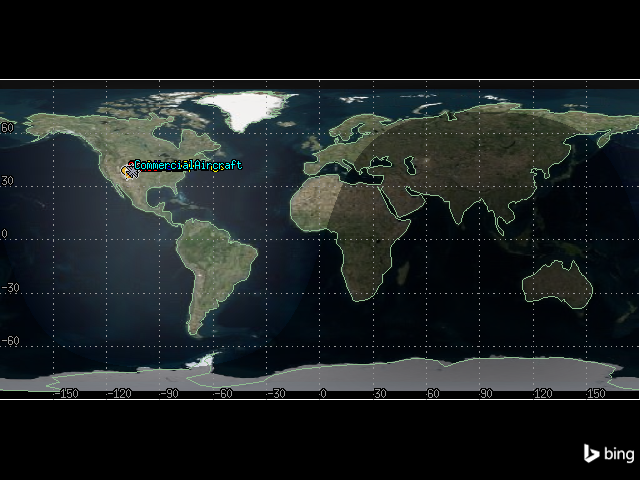

In [80]:
map_plotter.camera.position = [-1090, 35060, 0.0]
map_plotter.show()

## Create a flight profile by time report

To determine how much fuel is required for the mission, and how much payload can be carried on board the aircraft, create a flight profile by time report. In this report type, flight data is sampled using a constant time step between grid points. This report style is only available for Aviator propagated vehicles.

Select the report from the aircraft's `data_providers` method, calculate the data for every minute between the scenario's start and stop times, and convert the report to a pandas dataframe:

In [81]:
flight_profile_df = (
    aircraft.data_providers.item("Flight Profile By Time")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)

Select the columns of the dataframe corresponding to the aircraft's weight and fuel state, then select the first and last rows of each:

In [82]:
flight_profile_df[["weight", "fuel state"]].iloc[[0, -1]]

,weight,fuel state
0,51000.0,20000.0
42,44388.42275516406,13388.42275516408


The first row corresponds to the aircraft's starting weight and fuel state, and the last row corresponds to the ending weight and fuel state. The plane is approximately $4404$ lb above its maximum landing weight of $40000$ lbs when it touches down, and lands with approximately $13404$ lb of fuel.

## Adjust the initial fuel state

To ensure that the aircraft does not land with a weight higher than its maximum landing weight, it is possible to adjust either the initial fuel state or payload. In this case, because the aircraft landed with more fuel than necessary, adjust the initial fuel state. Remove $6000$ pounds of fuel by setting the initial fuel state to $14000$ lb:

In [83]:
internal_fuel.initial_fuel_state = 14000

Then, update the aircraft's route and re-calculate the flight profile by time report:

In [84]:
aircraft.route.aviator_propagator.propagate()
flight_profile_df = (
    aircraft.data_providers.item("Flight Profile By Time")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)
flight_profile_df[["weight", "fuel state"]].iloc[[0, -1]]

,weight,fuel state
0,45000.0,14000.0
42,38547.50572913153,7547.505729131538


The aircraft's landing weight is now under the maximum weight, and it still has approximately $7561$ lb of fuel upon landing.

## Visualize the adjusted fuel state over time

Plot the aircraft's weight and fuel state over the duration of its flight:

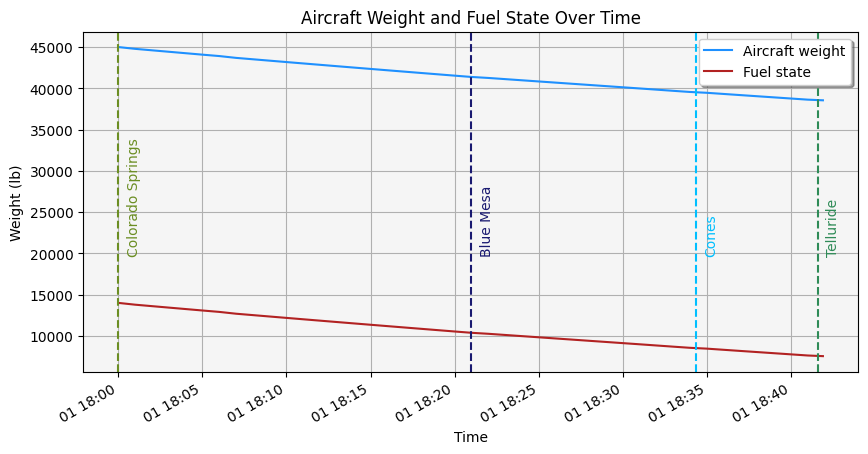

In [85]:
import datetime as dt

from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


flight_profile_df = (
    aircraft.data_providers.item("Flight Profile By Time")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)
flight_profile_df[["weight", "fuel state", "time"]]

# Convert data to correct types
flight_profile_df["time"] = pd.to_datetime(flight_profile_df["time"])
flight_profile_df["weight"] = pd.to_numeric(flight_profile_df["weight"])
flight_profile_df["fuel state"] = pd.to_numeric(flight_profile_df["fuel state"])

# Plot data
ax = flight_profile_df.plot(
    x="time", y="weight", color="dodgerblue", label="Aircraft weight"
)
ax = flight_profile_df.plot(
    x="time", y="fuel state", color="firebrick", ax=ax, label="Fuel state"
)

# Set title and axes labels
ax.set_title("Aircraft Weight and Fuel State Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Weight (lb)")

# Configure style
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")
ax.legend(shadow=True)

# Add waypoint information
lla_position_df = (
    aircraft.data_providers.item("LLA State")
    .group.item(1)
    .execute(scenario.start_time, scenario.stop_time, 1)
    .data_sets.to_pandas_dataframe()
)


def find_waypoint_time(waypoint_lat, waypoint_lon, lla_df):
    """Compute the time at which the aircraft flies over a waypoint."""
    valid_lats = np.isclose(
        np.array(lla_df["lat"], dtype=float),
        np.full(len(lla_df), waypoint_lat, dtype=float),
        rtol=1e-03,
    )
    valid_lons = np.isclose(
        np.array(lla_df["lon"], dtype=float),
        np.full(len(lla_df), waypoint_lon, dtype=float),
    )
    return parser.parse(
        (lla_df[np.logical_and(valid_lats, valid_lons)]["time"]).iloc[0]
    )


telluride_time = find_waypoint_time(
    telluride_runway.get_value("Latitude"),
    telluride_runway.get_value("Longitude"),
    lla_position_df,
)
ax.axvline(telluride_time, label="Telluride", color="seagreen", linestyle="--")
plt.text(
    telluride_time + dt.timedelta(seconds=30),
    20000,
    "Telluride",
    rotation=90,
    color="seagreen",
)
colorado_springs_time = find_waypoint_time(
    colorado_springs_runway.get_value("Latitude"),
    colorado_springs_runway.get_value("Longitude"),
    lla_position_df,
)
ax.axvline(
    colorado_springs_time, label="Colorado Springs", color="olivedrab", linestyle="--"
)
plt.text(
    colorado_springs_time + dt.timedelta(seconds=30),
    20000,
    "Colorado Springs",
    rotation=90,
    color="olivedrab",
)
cones_time = find_waypoint_time(
    cones_navaid.get_value("Latitude"),
    cones_navaid.get_value("Longitude"),
    lla_position_df,
)
ax.axvline(cones_time, label="Cones", color="deepskyblue", linestyle="--")
plt.text(
    cones_time + dt.timedelta(seconds=30),
    20000,
    "Cones",
    rotation=90,
    color="deepskyblue",
)
blue_mesa_time = find_waypoint_time(
    blue_mesa_navaid.get_value("Latitude"),
    blue_mesa_navaid.get_value("Longitude"),
    lla_position_df,
)
ax.axvline(blue_mesa_time, label="Blue Mesa", color="midnightblue", linestyle="--")
plt.text(
    blue_mesa_time + dt.timedelta(seconds=30),
    20000,
    "Blue Mesa",
    rotation=90,
    color="midnightblue",
)

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()